In [1]:
import pandas as pd, numpy as np, seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import random as random 
import math
df_train = pd.read_csv("train.csv")
np.random.seed(123)
n = len(df_train)

yes = df_train[df_train.Loan_Status=="Y"]
no = df_train[df_train.Loan_Status=="N"]
n_yes = df_train[df_train.Loan_Status=="Y"].shape[0]
n_no = df_train[df_train.Loan_Status=="N"].shape[0]

age_yes = np.concatenate( [np.random.randint(32,58,int(n_yes*0.7)),np.random.randint(18,29,int((n_yes*0.3)+1))])
age_no = np.concatenate( [np.random.randint(32,58,int(n_no*0.2)),np.random.randint(61,85,int(n_no*0.3)),np.random.randint(18,29,int((n_no*0.5)+1))])


mask_yes = df_train.Loan_Status == "Y"
mask_no  = df_train.Loan_Status == "N"

df_train.loc[mask_yes, "age"] = age_yes
df_train.loc[mask_no,  "age"] = age_no


df = df_train.copy()


def drop_id(df):
    if not df["Loan_ID"].is_unique:
        print("Duplicates detected. Removing...")
        df = df.drop_duplicates(subset="Loan_ID")
    else:
        print("No duplicates on Loan_ID and we droped this column")
    df = df.drop("Loan_ID", axis=1)
    return df

df = drop_id(df)

No duplicates on Loan_ID and we droped this column


## Preprocessing

We can see that there are outliers in the numerical variables. To address this issue, we replace the missing values for the numerical variables with the median. For the categorical variables, we replace them with the most frequent category.

In [2]:
def replace_missing_value(df):
    for col in df.columns:
        if df[col].isna().sum() > 0:
            if df[col].dtype == 'object' or df[col].nunique() < 15 :
                if not df[col].mode().empty:
                    most_frequent = df[col].mode()[0]
                    df[col] = df[col].fillna(most_frequent)
                    df[col].astype('object')
            elif pd.api.types.is_numeric_dtype(df[col]) and df[col].nunique() > 15:
                med_val = df[col].median()
                if pd.notna(med_val):
                    df[col] = df[col].fillna(med_val)   



In [3]:
replace_missing_value(df)
df.dtypes

Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
age                  float64
dtype: object

## Outliers

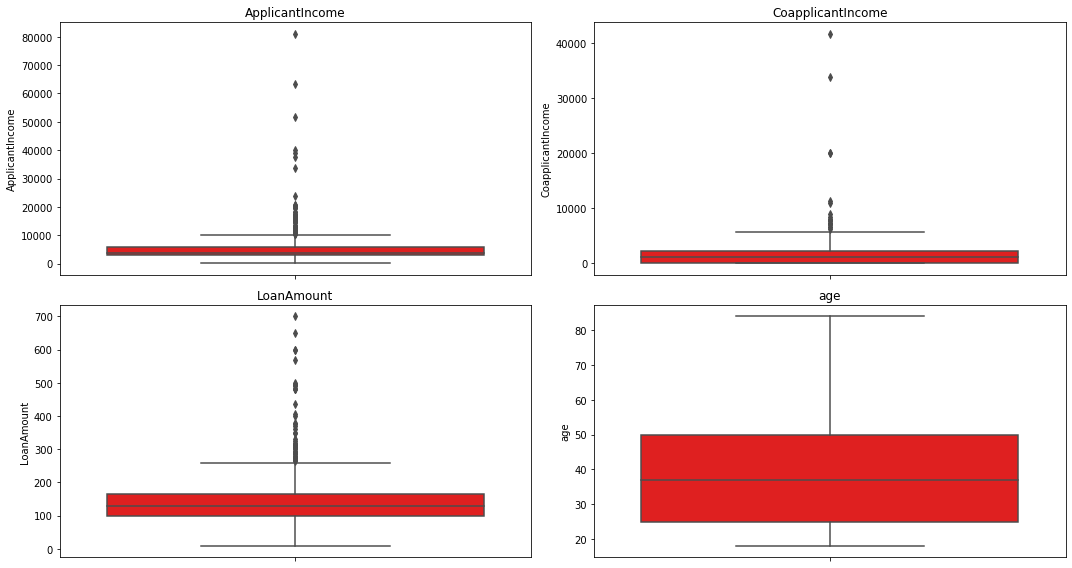

In [4]:
num_cols = df.select_dtypes(include=['float64', 'int64']).columns.difference(["Loan_Amount_Term", "Credit_History"])

plt.figure(figsize=(15,8))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(y=df[col], color="red")
    plt.title(f'{col}')
plt.tight_layout()
plt.show()



In [6]:
z = df[num_cols].apply(lambda x: (x - x.mean()) / x.std(ddof=0))


outliers = df[(z.abs() > 3).any(axis=1)]

print("Outliers :")
print(outliers.shape)


Outliers :
(25, 13)


In [7]:

def plot_outliers_hist(df, list_col, threshold=3):
    for i in range(0, len(list_col), 4):
        batch = list_col[i : i + 4]
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))
        axes = axes.flatten()
        for ax, col in zip(axes, batch):
            data = df[col].dropna()
            zs = (data - data.mean()) / data.std(ddof=0)
            outlier_mask = zs.abs() > threshold

            ax.hist(data, bins='auto', alpha=0.6,
                    color='lightcoral', edgecolor='darkred', linewidth=0.5)
            ax.scatter(data[outlier_mask], [0]*outlier_mask.sum(),
                       color='red', marker='o', label='Outliers', zorder=5)
            ax.set_title(f"{col} — outliers (|z| > {threshold})")
            ax.set_xlabel(col)
            ax.set_ylabel("Fréquence")
            ax.legend(fontsize='small')

        for j in range(len(batch), 4):
            fig.delaxes(axes[j])

        plt.tight_layout()
        plt.show()



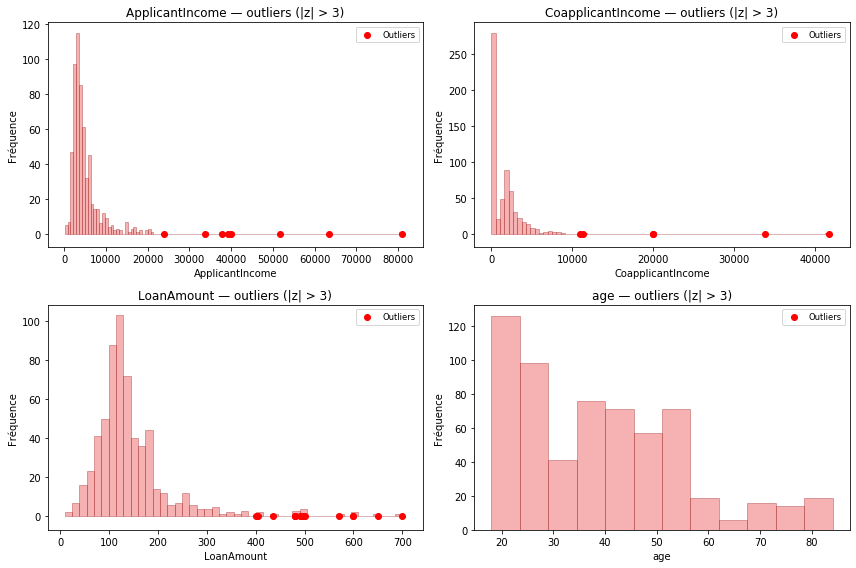

In [8]:
plot_outliers_hist(df, num_cols)

In [9]:
z_scores = stats.zscore(df[num_cols])
z_df = pd.DataFrame(z_scores, columns=num_cols, index=df.index)
threshold = 3
mask = (z_df.abs() <= threshold).all(axis=1)

df_sans_outliers = df[mask].copy()


In [10]:
df_sans_outliers.shape

(589, 13)

There are 589 observations remaining in our dataset.

## Feature Engineering

We added two variables calculated from the existing ones: 
Total_income = ApplicantIncome + CoapplicantIncome  (which is the applicant's income plus the co-applicant's income)
MonthlyPayment = LoanAmount*1000 / Loan_Amount_Term  (monthly loan amount requested, which is the loan amount divided by the loan term)
DebtToIncomeRatio = MonthlyPayment / TotalIncome

In [11]:
df_sans_outliers["LoanAmountScale"] = df_sans_outliers["LoanAmount"]*1000
df_sans_outliers = df_sans_outliers.drop("LoanAmount", axis=1)
df_sans_outliers["TotalIncome"] = df_sans_outliers["ApplicantIncome"] + df_sans_outliers["CoapplicantIncome"]
df_sans_outliers["MonthlyPayment"] = df_sans_outliers["LoanAmountScale"] / df_sans_outliers["Loan_Amount_Term"]
df_sans_outliers["DebtToIncomeRatio"] = df_sans_outliers["MonthlyPayment"] / (df_sans_outliers["TotalIncome"])


In [12]:
labels = ['1st part', '2nd part', '3rd part', '4th part', '5th part']
df_sans_outliers["TotalIncomeCut"] = pd.cut(df_sans_outliers['TotalIncome'], bins=5, labels=labels)

In [13]:
df_sans_outliers.head(10)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,age,LoanAmountScale,TotalIncome,MonthlyPayment,DebtToIncomeRatio,TotalIncomeCut
0,Male,No,0,Graduate,No,5849,0.0,360.0,1.0,Urban,Y,45.0,128000.0,5849.0,355.555556,0.060789,2nd part
1,Male,Yes,1,Graduate,No,4583,1508.0,360.0,1.0,Rural,N,48.0,128000.0,6091.0,355.555556,0.058374,2nd part
2,Male,Yes,0,Graduate,Yes,3000,0.0,360.0,1.0,Urban,Y,34.0,66000.0,3000.0,183.333333,0.061111,1st part
3,Male,Yes,0,Not Graduate,No,2583,2358.0,360.0,1.0,Urban,Y,34.0,120000.0,4941.0,333.333333,0.067463,1st part
4,Male,No,0,Graduate,No,6000,0.0,360.0,1.0,Urban,Y,38.0,141000.0,6000.0,391.666667,0.065278,2nd part
5,Male,Yes,2,Graduate,Yes,5417,4196.0,360.0,1.0,Urban,Y,49.0,267000.0,9613.0,741.666667,0.077152,3rd part
6,Male,Yes,0,Not Graduate,No,2333,1516.0,360.0,1.0,Urban,Y,51.0,95000.0,3849.0,263.888889,0.068560,1st part
7,Male,Yes,3+,Graduate,No,3036,2504.0,360.0,0.0,Semiurban,N,36.0,158000.0,5540.0,438.888889,0.079222,2nd part
8,Male,Yes,2,Graduate,No,4006,1526.0,360.0,1.0,Urban,Y,42.0,168000.0,5532.0,466.666667,0.084358,2nd part
10,Male,Yes,2,Graduate,No,3200,700.0,360.0,1.0,Urban,Y,57.0,70000.0,3900.0,194.444444,0.049858,1st part


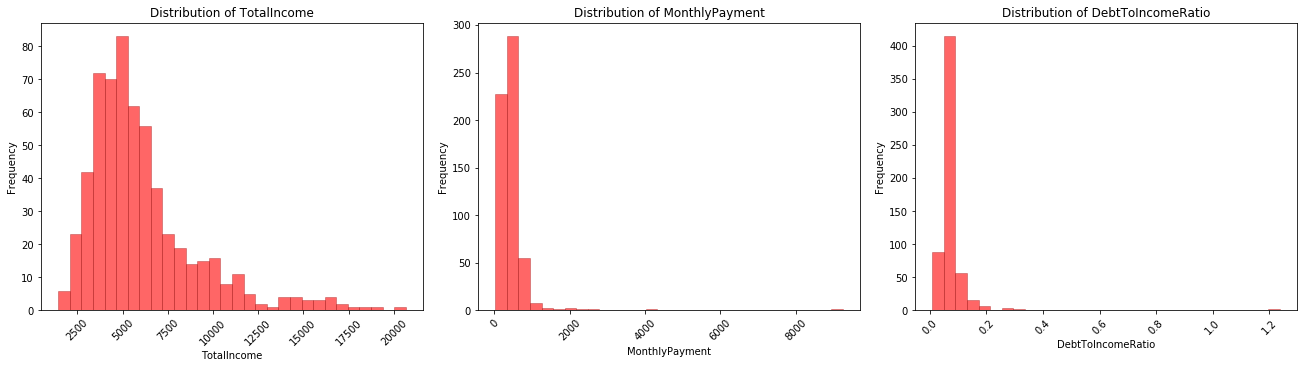

In [15]:
cols = ["TotalIncome", "MonthlyPayment", "DebtToIncomeRatio"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)

for ax, col in zip(axes, cols):
    data = df_sans_outliers[col].dropna()
    if data.empty:
        ax.set_visible(False)
        continue

    counts, bins, patches = ax.hist(
        data,
        bins=30,
        density=False,
        alpha=0.6,
        edgecolor="darkred",
        linewidth=0.5,
        color="red"
    )


    try:
        kde = gaussian_kde(data)
        x_vals = np.linspace(data.min(), data.max(), 200)
        bin_width = bins[1] - bins[0]
        scale = len(data) * bin_width 
        ax.plot(x_vals, kde(x_vals) * scale, linestyle="--", color="red")
    except Exception:
        pass 

    ax.set_title(f"Distribution of {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")
    ax.tick_params(axis="x", rotation=45)

plt.show()


In [16]:
def stacked_target_by_category(df, col, target="Loan_Status", color_map=None):
    if color_map is None:
        color_map = {"Y": "#c0392b", "N": "#867978"}

    sub = df[[col, target]].dropna(subset=[col, target])
    if sub.empty:
        raise ValueError(f"Aucune donnée valide pour la colonne '{col}' et la cible '{target}'.")

    ct = pd.crosstab(sub[col], sub[target], normalize="index")


    for status in ["Y", "N"]:
        if status not in ct.columns:
            ct[status] = 0.0
    ct = ct[["Y", "N"]]

    fig, ax = plt.subplots(figsize=(8, 5))
    ct.plot(
        kind="bar",
        stacked=True,
        ax=ax,
        color=[color_map["Y"], color_map["N"]],
        legend=False
    )

    ax.set_title(f"{target} proportion by {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Proportion")
    ax.set_ylim(0, 1)
    ax.tick_params(axis="x", rotation=45)

    legend_handles = [
        Patch(color=color_map["Y"], label="Y"),
        Patch(color=color_map["N"], label="N")
    ]
    ax.legend(handles=legend_handles, title=target, loc="upper right", frameon=True)

    plt.tight_layout()
    plt.show()

    return fig, ax

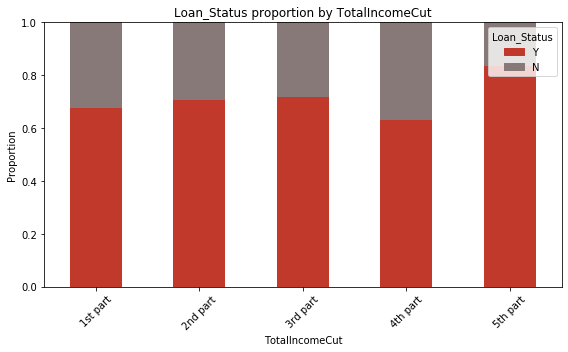

(<Figure size 576x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x22741b4f508>)

In [17]:
stacked_target_by_category(df=df_sans_outliers, col="TotalIncomeCut", target="Loan_Status")